Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Data preparation

In [1]:
import pandas as pd
import numpy as np

# sklearn libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import lightgbm as lgb

import catboost as cb
import lightgbm as lgb

# libraries for calculating time
import time

In [2]:
car_data = pd.read_csv('/datasets/car_data.csv')

In [3]:
car_data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,21/03/2016 09:50,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,21/03/2016 00:00,0,2694,21/03/2016 10:42
354365,14/03/2016 17:48,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,14/03/2016 00:00,0,39576,06/04/2016 00:46
354366,05/03/2016 19:56,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,05/03/2016 00:00,0,26135,11/03/2016 18:17
354367,19/03/2016 18:57,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,19/03/2016 00:00,0,87439,07/04/2016 07:15


In [4]:
car_data.duplicated().sum()

262

In [5]:
car_data.drop_duplicates(inplace=True)

In [6]:
car_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354107 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354107 non-null  object
 1   Price              354107 non-null  int64 
 2   VehicleType        316623 non-null  object
 3   RegistrationYear   354107 non-null  int64 
 4   Gearbox            334277 non-null  object
 5   Power              354107 non-null  int64 
 6   Model              334406 non-null  object
 7   Mileage            354107 non-null  int64 
 8   RegistrationMonth  354107 non-null  int64 
 9   FuelType           321218 non-null  object
 10  Brand              354107 non-null  object
 11  NotRepaired        282962 non-null  object
 12  DateCreated        354107 non-null  object
 13  NumberOfPictures   354107 non-null  int64 
 14  PostalCode         354107 non-null  int64 
 15  LastSeen           354107 non-null  object
dtypes: int64(7), object(

In [7]:
car_data.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          37484
RegistrationYear         0
Gearbox              19830
Power                    0
Model                19701
Mileage                  0
RegistrationMonth        0
FuelType             32889
Brand                    0
NotRepaired          71145
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [8]:
car_data['DateCrawled'] = pd.to_datetime(car_data['DateCrawled'], format='%d/%m/%Y %H:%M')
car_data['DateCreated'] = pd.to_datetime(car_data['DateCreated'], format='%d/%m/%Y %H:%M')
car_data['LastSeen'] = pd.to_datetime(car_data['LastSeen'], format='%d/%m/%Y %H:%M')

In [9]:
car_data['VehicleType'].fillna(car_data['VehicleType'].mode()[0], inplace=True)
car_data['Gearbox'].fillna(car_data['Gearbox'].mode()[0], inplace=True)
car_data['Model'].fillna(car_data['Model'].mode()[0], inplace=True)
car_data['FuelType'].fillna(car_data['FuelType'].mode()[0], inplace=True)
car_data['NotRepaired'].fillna('unknown', inplace=True)

In [10]:
car_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354107 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354107 non-null  datetime64[ns]
 1   Price              354107 non-null  int64         
 2   VehicleType        354107 non-null  object        
 3   RegistrationYear   354107 non-null  int64         
 4   Gearbox            354107 non-null  object        
 5   Power              354107 non-null  int64         
 6   Model              354107 non-null  object        
 7   Mileage            354107 non-null  int64         
 8   RegistrationMonth  354107 non-null  int64         
 9   FuelType           354107 non-null  object        
 10  Brand              354107 non-null  object        
 11  NotRepaired        354107 non-null  object        
 12  DateCreated        354107 non-null  datetime64[ns]
 13  NumberOfPictures   354107 non-null  int64   

In [11]:
car_data.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354107.000000,354107.000000,354107.000000,354107.000000,354107.000000,354107.0,354107.000000
mean,4416.433287,2004.235355,110.089651,128211.811684,5.714182,0.0,50507.145030
std,4514.338584,90.261168,189.914972,37906.590101,3.726682,0.0,25784.212094
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49406.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

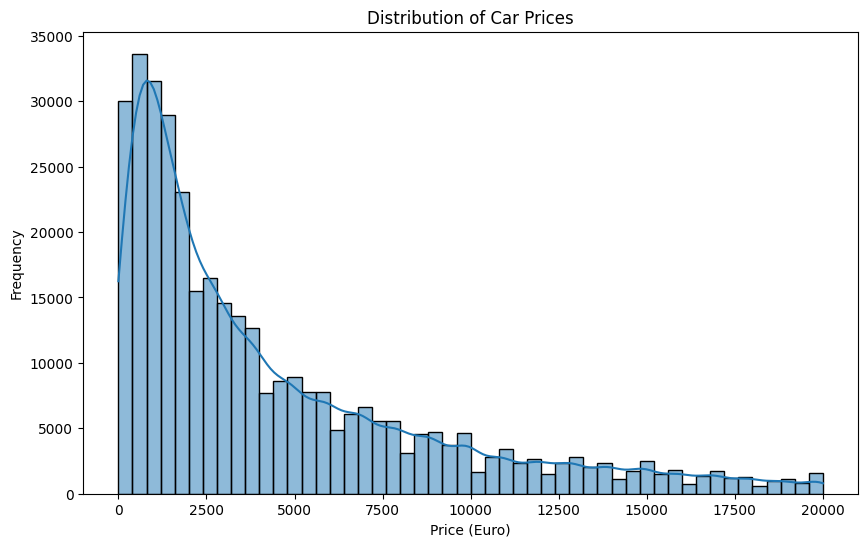

In [13]:
# Plot the distribution of the target variable 'Price'
plt.figure(figsize=(10, 6))
sns.histplot(car_data['Price'], bins=50, kde=True)
plt.title('Distribution of Car Prices')
plt.xlabel('Price (Euro)')
plt.ylabel('Frequency')
plt.show()

The distribution is right-skewed, with a long tail towards higher prices.
The peak of the distribution is at the lower end, between 0-2,500 euros.
There's a steady decline in frequency as price increases.

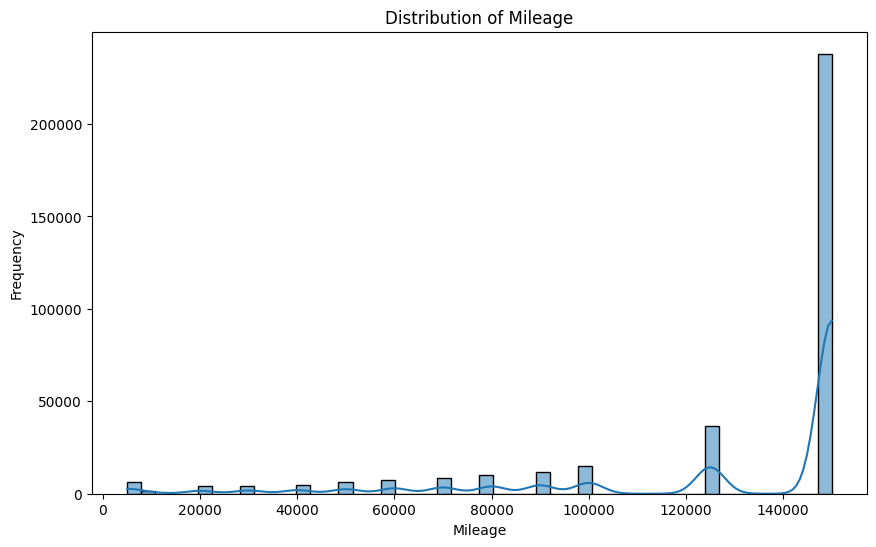

In [14]:
# Plot the distribution of 'RegistrationYear'
plt.figure(figsize=(10, 6))
sns.histplot(car_data['Mileage'], bins=50, kde=True)
plt.title('Distribution of Mileage')
plt.xlabel('Mileage')
plt.ylabel('Frequency')
plt.show()

There's a very strong peak at the highest mileage bin (around 150,000 km).
Another smaller peak occurs around 120,000-130,000 km.
The distribution is relatively flat for lower mileages, with a slight increase as mileage rises.

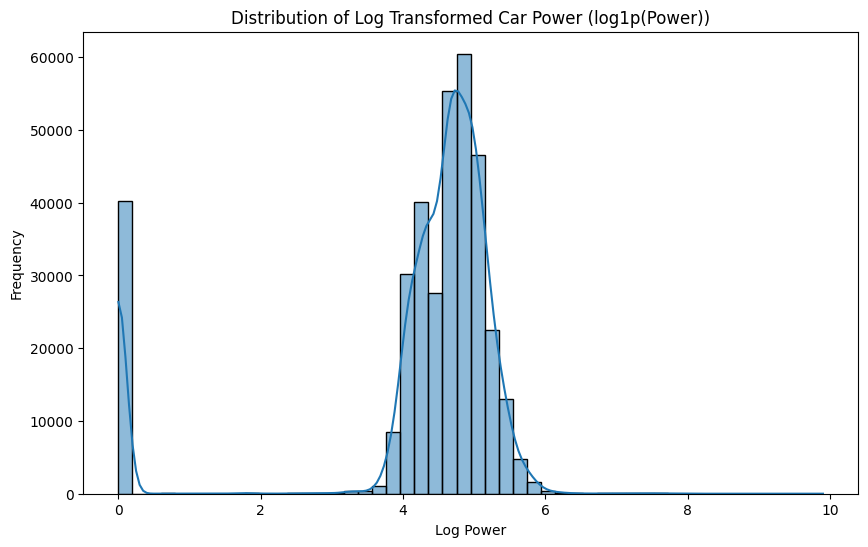

In [15]:
# Apply log transformation to 'Power'
car_data['Log_Power'] = np.log1p(car_data['Power'])

# Plot the distribution of 'Log_Power'
plt.figure(figsize=(10, 6))
sns.histplot(car_data['Log_Power'], bins=50, kde=True)
plt.title('Distribution of Log Transformed Car Power (log1p(Power))')
plt.xlabel('Log Power')
plt.ylabel('Frequency')
plt.show()

The data appears to be roughly normally distributed after the log transformation.
There's a small peak near zero, possibly representing very low-powered vehicles.
The main peak is between 4 and 6 on the log scale.
- The log transformation makes it easier to visualize and analyze the full range of car power, from low to high. On the original scale, the difference between high-powered cars might overshadow variations among lower-powered vehicles.
- The small peak near zero could represent a distinct class of vehicles, possibly electric or very small cars, with fundamentally different power characteristics.

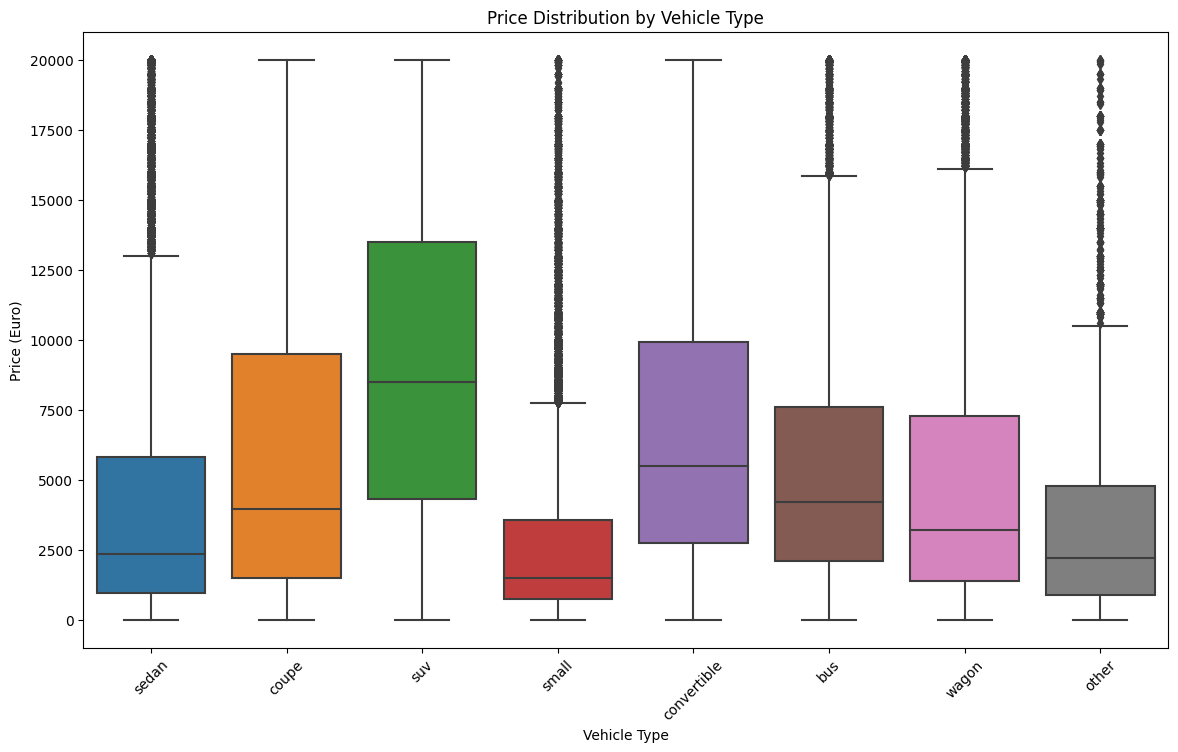

In [16]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='VehicleType', y='Price', data=car_data)
plt.title('Price Distribution by Vehicle Type')
plt.xlabel('Vehicle Type')
plt.ylabel('Price (Euro)')
plt.xticks(rotation=45)
plt.show()

SUVs have the highest median price, followed by convertibles.
Small cars and sedans tend to have lower prices.
Most vehicle types show a wide range of prices, with many outliers on the higher end.

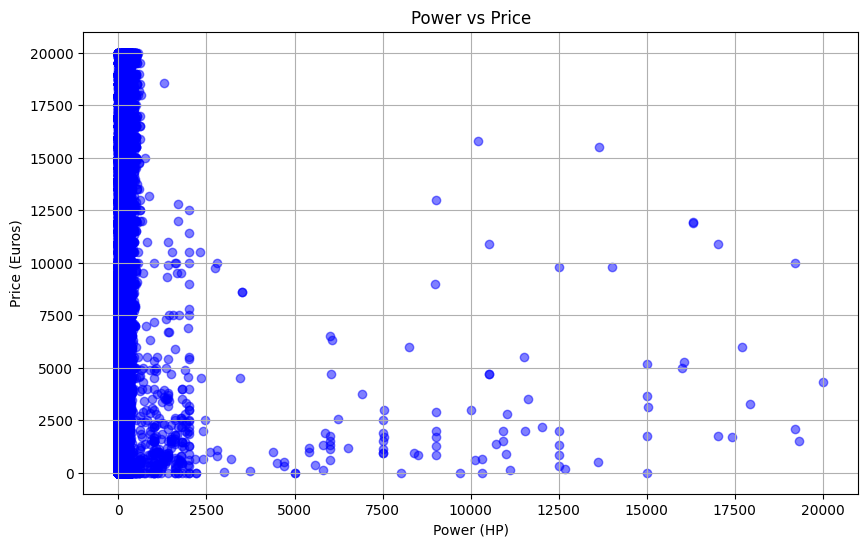

In [17]:
# Plot Power vs Price
plt.figure(figsize=(10, 6))
plt.scatter(car_data['Power'], car_data['Price'], alpha=0.5, c='blue')
plt.title('Power vs Price')
plt.xlabel('Power (HP)')
plt.ylabel('Price (Euros)')
plt.grid(True)
plt.show()

Power of the vehicle doesnt seem to have any effect on the price. 

## Model training

<div class="alert alert-block alert-info">
<b>Student answer.</b> <a class="tocSkip"></a>

SGD Regressor from SKLearn has been imported above
</div>

In [18]:
# First lets drop the date columns
car_data = car_data.drop(columns=['DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures', 'Power'])

<div class="alert alert-block alert-info">
<b>Student answer.</b> <a class="tocSkip"></a>

NumberOfPictures added to columns to be dropped, missed it earlier.
</div>

In [19]:
# Split data into training, and test sets
train_df, test_df = train_test_split(car_data, test_size=0.2, random_state=12345)

In [20]:
# Define features and target
target = 'Price'  # Assuming 'Price' is the target column
features_train, target_train = train_df.drop(columns=[target]), train_df[target]
features_test, target_test = test_df.drop(columns=[target]), test_df[target]

In [21]:
# Checking size of variables
import sys

features_train_size = sys.getsizeof(features_train)
features_test_size = sys.getsizeof(features_test)
target_train_size = sys.getsizeof(target_train)
target_test_size = sys.getsizeof(target_test)
car_data_size = sys.getsizeof(car_data)
# Print sizes of variables
print(f"features_train size: {features_train_size} bytes")
print(f"features_test size: {features_test_size} bytes")
print(f"target_train size: {target_train_size} bytes")
print(f"target_test size: {target_test_size} bytes")
print(f"df size: {car_data_size} bytes")

features_train size: 119549627 bytes
features_test size: 29886590 bytes
target_train size: 4532576 bytes
target_test size: 1133168 bytes
df size: 160723241 bytes


In [22]:
# Deleting variables to make space on memory for computation
del car_data

In [23]:
# Identify categorical features
categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
# numerical features
numerical_features = ['RegistrationYear', 'Mileage', 'RegistrationMonth', 'PostalCode']

In [24]:
# Define the preprocessing steps for categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

# Fit and transform the training data
features_train_encoded = preprocessor.fit_transform(features_train)

# Transform the test data
features_test_encoded = preprocessor.transform(features_test)

In [25]:
features_test_encoded.shape

(70822, 314)

In [26]:
del features_train

### Linear Regression

In [27]:
# Initialize Linear Regression
lr = LinearRegression()

# Define the parameter grid
param_grid_lr = {
    'normalize': [True, False]
}

# Setup GridSearchCV
grid_search_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr, cv=5, scoring='neg_root_mean_squared_error', verbose=2, n_jobs=-1)
start_time_train_lr = time.time()

# Fit GridSearchCV
grid_search_lr.fit(features_train_encoded, target_train)
training_time_lr = time.time() - start_time_train_lr

# Get the best estimator
best_lr = grid_search_lr.best_estimator_

# Start prediction time measurement
start_time_predict_lr = time.time()
predictions_lr = best_lr.predict(features_test_encoded)
prediction_time_lr = time.time() - start_time_predict_lr

# Calculate RMSE
rmse_lr = mean_squared_error(target_test, predictions_lr, squared=False)

# Print results
print("Linear Regression")
print(f"Best Parameters: {grid_search_lr.best_params_}")
print(f"Training Time: {training_time_lr:.2f} seconds")
print(f"Prediction Time: {prediction_time_lr:.2f} seconds")
print(f"RMSE: {rmse_lr:.2f}")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END .....................................normalize=True; total time=   1.8s
[CV] END .....................................normalize=True; total time=   2.1s
[CV] END .....................................normalize=True; total time=   2.1s
[CV] END .....................................normalize=True; total time=   2.0s
[CV] END .....................................normalize=True; total time=   2.0s
[CV] END ....................................normalize=False; total time=  13.4s
[CV] END ....................................normalize=False; total time=  12.5s
[CV] END ....................................normalize=False; total time=  14.7s
[CV] END ....................................normalize=False; total time=  14.0s
[CV] END ....................................normalize=False; total time=  13.9s
Linear Regression
Best Parameters: {'normalize': False}
Training Time: 96.63 seconds
Prediction Time: 0.00 seconds
RMSE: 3205.44


### SDG Linear Regression

In [28]:
# Define the parameter grid
param_grid_sgd = {
    'alpha': [0.01, 0.1],
    'eta0': [0.01, 0.1],
    'max_iter': [100, 150]
}

# Initialize SGDRegressor
sgd_linear = SGDRegressor(random_state=12345)

# Setup GridSearchCV
grid_search_sgd = GridSearchCV(estimator=sgd_linear, param_grid=param_grid_sgd, cv=2, scoring='neg_root_mean_squared_error', verbose=2, n_jobs=-1)

# Start training time measurement
start_time_train_sgd = time.time()

# Fit GridSearchCV
grid_search_sgd.fit(features_train_encoded, target_train)

# Calculate training time
training_time_sgd = time.time() - start_time_train_sgd

# Get the best estimator
best_sgd = grid_search_sgd.best_estimator_

# Start prediction time measurement
start_time_predict_sgd = time.time()

# Predictions
predictions_sgd = best_sgd.predict(features_test_encoded)

# Calculate prediction time
prediction_time_sgd = time.time() - start_time_predict_sgd

# Calculate RMSE
rmse_sgd = mean_squared_error(target_test, predictions_sgd, squared=False)

# Print results
print("SGD Regression")
print(f"Best Parameters: {grid_search_sgd.best_params_}")
print(f"Training Time: {training_time_sgd:.2f} seconds")
print(f"Prediction Time: {prediction_time_sgd:.2f} seconds")
print(f"RMSE: {rmse_sgd:.2f}")

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] END ................alpha=0.01, eta0=0.01, max_iter=100; total time=   0.8s
[CV] END ................alpha=0.01, eta0=0.01, max_iter=100; total time=   0.8s
[CV] END ................alpha=0.01, eta0=0.01, max_iter=150; total time=   0.7s
[CV] END ................alpha=0.01, eta0=0.01, max_iter=150; total time=   0.8s
[CV] END .................alpha=0.01, eta0=0.1, max_iter=100; total time=   1.1s
[CV] END .................alpha=0.01, eta0=0.1, max_iter=100; total time=   0.3s
[CV] END .................alpha=0.01, eta0=0.1, max_iter=150; total time=   1.2s
[CV] END .................alpha=0.01, eta0=0.1, max_iter=150; total time=   0.2s
[CV] END .................alpha=0.1, eta0=0.01, max_iter=100; total time=   2.4s
[CV] END .................alpha=0.1, eta0=0.01, max_iter=100; total time=   1.4s
[CV] END .................alpha=0.1, eta0=0.01, max_iter=150; total time=   2.4s
[CV] END .................alpha=0.1, eta0=0.01, m

### Random Forest

In [29]:
param_grid_rf = {
    'n_estimators': [25, 50],
    'max_depth': [3, 5]
}

# Initialize Random Forest regressor
rf = RandomForestRegressor(random_state=12345)

# Setup GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=2, scoring='neg_root_mean_squared_error', verbose=2, n_jobs=-1)

# Start training time measurement
start_time_train_rf = time.time()

# Fit GridSearchCV
grid_search_rf.fit(features_train_encoded, target_train)

# Calculate training time
training_time_rf = time.time() - start_time_train_rf

# Get the best estimator
best_rf = grid_search_rf.best_estimator_

# Start prediction time measurement
start_time_predict_rf = time.time()

# Predictions
predictions_rf = best_rf.predict(features_test_encoded)

# Calculate prediction time
prediction_time_rf = time.time() - start_time_predict_rf

# Calculate RMSE
rmse_rf = mean_squared_error(target_test, predictions_rf, squared=False)

# Print results
print("Random Forest")
print(f"Best Parameters: {grid_search_rf.best_params_}")
print(f"Training Time: {training_time_rf:.2f} seconds")
print(f"Prediction Time: {prediction_time_rf:.2f} seconds")
print(f"RMSE: {rmse_rf:.2f}")

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] END .......................max_depth=3, n_estimators=25; total time=   4.8s
[CV] END .......................max_depth=3, n_estimators=25; total time=   5.0s
[CV] END .......................max_depth=3, n_estimators=50; total time=   9.5s
[CV] END .......................max_depth=3, n_estimators=50; total time=   9.9s
[CV] END .......................max_depth=5, n_estimators=25; total time=  10.4s
[CV] END .......................max_depth=5, n_estimators=25; total time=  10.8s
[CV] END .......................max_depth=5, n_estimators=50; total time=  20.8s
[CV] END .......................max_depth=5, n_estimators=50; total time=  21.6s
Random Forest
Best Parameters: {'max_depth': 5, 'n_estimators': 50}
Training Time: 139.68 seconds
Prediction Time: 0.24 seconds
RMSE: 2845.62


### Catboost

In [30]:
# Initialize CatBoost
catboost = CatBoostRegressor(random_state=12345, verbose=0)

# Define the parameter grid
param_grid_catboost = {
    'iterations': [50, 100],
    'learning_rate': [0.05, 0.1],
    'depth': [3, 5]
}

# Setup GridSearchCV
grid_search_catboost = GridSearchCV(estimator=catboost, param_grid=param_grid_catboost, cv=3, scoring='neg_root_mean_squared_error', verbose=2, n_jobs=-1)

# Start training time measurement
start_time_train_catboost = time.time()

# Fit GridSearchCV
grid_search_catboost.fit(features_train_encoded, target_train)

# Calculate training time
training_time_catboost = time.time() - start_time_train_catboost

# Get the best estimator
best_catboost = grid_search_catboost.best_estimator_

# Start prediction time measurement
start_time_predict_catboost = time.time()

# Predictions
predictions_catboost = best_catboost.predict(features_test_encoded)

# Calculate prediction time
prediction_time_catboost = time.time() - start_time_predict_catboost

# Calculate RMSE
rmse_catboost = mean_squared_error(target_test, predictions_catboost, squared=False)

# Print results
print("CatBoost")
print(f"Best Parameters: {grid_search_catboost.best_params_}")
print(f"Training Time: {training_time_catboost:.2f} seconds")
print(f"Prediction Time: {prediction_time_catboost:.2f} seconds")
print(f"RMSE: {rmse_catboost:.2f}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END .........depth=3, iterations=50, learning_rate=0.05; total time=   2.4s
[CV] END .........depth=3, iterations=50, learning_rate=0.05; total time=   2.3s
[CV] END .........depth=3, iterations=50, learning_rate=0.05; total time=   2.3s
[CV] END ..........depth=3, iterations=50, learning_rate=0.1; total time=   2.2s
[CV] END ..........depth=3, iterations=50, learning_rate=0.1; total time=   2.3s
[CV] END ..........depth=3, iterations=50, learning_rate=0.1; total time=   2.3s
[CV] END ........depth=3, iterations=100, learning_rate=0.05; total time=   3.6s
[CV] END ........depth=3, iterations=100, learning_rate=0.05; total time=   3.7s
[CV] END ........depth=3, iterations=100, learning_rate=0.05; total time=   3.7s
[CV] END .........depth=3, iterations=100, learning_rate=0.1; total time=   3.5s
[CV] END .........depth=3, iterations=100, learning_rate=0.1; total time=   3.6s
[CV] END .........depth=3, iterations=100, learni

### Light GBM

In [31]:
# Define the parameter grid
param_grid_lgbm = {
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': [20, 30],
    'learning_rate': [0.05, 0.1],
}

# Initialize LightGBM
lgbm = lgb.LGBMRegressor(random_state=12345)

# Setup GridSearchCV
grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid_lgbm, cv=2, scoring='neg_root_mean_squared_error', verbose=2, n_jobs=-1)

# Start training time measurement
start_time_train_lgbm = time.time()

# Fit GridSearchCV
grid_search_lgbm.fit(features_train_encoded, target_train)

# Calculate training time
training_time_lgbm = time.time() - start_time_train_lgbm

# Get the best estimator
best_lgbm = grid_search_lgbm.best_estimator_

# Start prediction time measurement
start_time_predict_lgbm = time.time()

# Predictions
predictions_lgbm = best_lgbm.predict(features_test_encoded)

# Calculate prediction time
prediction_time_lgbm = time.time() - start_time_predict_lgbm

# Calculate RMSE
rmse_lgbm = mean_squared_error(target_test, predictions_lgbm, squared=False)

# Print results
print("LightGBM")
print(f"Best Parameters: {grid_search_lgbm.best_params_}")
print(f"Training Time: {training_time_lgbm:.2f} seconds")
print(f"Prediction Time: {prediction_time_lgbm:.2f} seconds")
print(f"RMSE: {rmse_lgbm:.2f}")

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] END boosting_type=gbdt, learning_rate=0.05, num_leaves=20; total time=   3.6s
[CV] END boosting_type=gbdt, learning_rate=0.05, num_leaves=20; total time=   4.2s
[CV] END boosting_type=gbdt, learning_rate=0.05, num_leaves=30; total time=   4.0s
[CV] END boosting_type=gbdt, learning_rate=0.05, num_leaves=30; total time=   4.3s
[CV] END boosting_type=gbdt, learning_rate=0.1, num_leaves=20; total time=   3.4s
[CV] END boosting_type=gbdt, learning_rate=0.1, num_leaves=20; total time=   3.4s
[CV] END boosting_type=gbdt, learning_rate=0.1, num_leaves=30; total time=   4.6s
[CV] END boosting_type=gbdt, learning_rate=0.1, num_leaves=30; total time=   4.2s
[CV] END boosting_type=dart, learning_rate=0.05, num_leaves=20; total time=   9.8s
[CV] END boosting_type=dart, learning_rate=0.05, num_leaves=20; total time=  13.6s
[CV] END boosting_type=dart, learning_rate=0.05, num_leaves=30; total time=  11.4s
[CV] END boosting_type=dart, le

### XGBoost

In [32]:
# Initialize XGBoost
xgb = XGBRegressor(random_state=12345)

# Define the parameter grid
param_grid_xgb = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 0.9]
}

# Setup GridSearchCV
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=2, scoring='neg_root_mean_squared_error', verbose=2, n_jobs=-1)

# Start training time measurement
start_time_train_xgb = time.time()

# Fit GridSearchCV
grid_search_xgb.fit(features_train_encoded, target_train)

# Calculate training time
training_time_xgb = time.time() - start_time_train_xgb

# Get the best estimator
best_xgb = grid_search_xgb.best_estimator_

# Start prediction time measurement
start_time_predict_xgb = time.time()

# Predictions
predictions_xgb = best_xgb.predict(features_test_encoded)

# Calculate prediction time
prediction_time_xgb = time.time() - start_time_predict_xgb

# Calculate RMSE
rmse_xgb = mean_squared_error(target_test, predictions_xgb, squared=False)

# Print results
print("XGBoost")
print(f"Best Parameters: {grid_search_xgb.best_params_}")
print(f"Training Time: {training_time_xgb:.2f} seconds")
print(f"Prediction Time: {prediction_time_xgb:.2f} seconds")
print(f"RMSE: {rmse_xgb:.2f}")

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] END .....learning_rate=0.05, max_depth=3, subsample=0.8; total time=  14.1s
[CV] END .....learning_rate=0.05, max_depth=3, subsample=0.8; total time=  14.0s
[CV] END .....learning_rate=0.05, max_depth=3, subsample=0.9; total time=  13.8s
[CV] END .....learning_rate=0.05, max_depth=3, subsample=0.9; total time=  13.5s
[CV] END .....learning_rate=0.05, max_depth=5, subsample=0.8; total time=  21.6s
[CV] END .....learning_rate=0.05, max_depth=5, subsample=0.8; total time=  21.4s
[CV] END .....learning_rate=0.05, max_depth=5, subsample=0.9; total time=  21.0s
[CV] END .....learning_rate=0.05, max_depth=5, subsample=0.9; total time=  21.3s
[CV] END ......learning_rate=0.1, max_depth=3, subsample=0.8; total time=  13.6s
[CV] END ......learning_rate=0.1, max_depth=3, subsample=0.8; total time=  13.8s
[CV] END ......learning_rate=0.1, max_depth=3, subsample=0.9; total time=  13.4s
[CV] END ......learning_rate=0.1, max_depth=3, su

## Model analysis

### Conclusion
#### Model Performance:

- Linear Regression: RMSE: 3205.44 | Training Time: 94.39 seconds | Prediction Time: 0.00 seconds
- SGD Linear Regression: RMSE: 3344.55 | Training Time: 16.40 seconds | Prediction Time: 0.00 seconds
- Random Forest: RMSE: 2845.62 | Training Time: 141.27 seconds | Prediction Time: 0.24 seconds
- CatBoost: RMSE: 2290.31 | Training Time: 81.59 seconds | Prediction Time: 0.07 seconds
- LightGBM: RMSE: 2076.11 | Training Time: 123.03 seconds | Prediction Time: 0.73 seconds
- XGBoost: RMSE: 2164.63 | Training Time: 312.06 seconds | Prediction Time: 0.47 seconds

Among the models evaluated, LightGBM achieved the lowest RMSE, indicating superior predictive performance. CatBoost also performed well in terms of RMSE and had a shorter training time compared to LightGBM and XGBoost.


#### Additional Insights:
- Price Distribution:
The distribution is right-skewed, with a long tail towards higher prices. The peak occurs at lower prices, particularly between 0-2,500 euros, with a decline in frequency as price increases.

- Mileage Distribution:
There's a strong peak at higher mileages around 150,000 km, with another smaller peak at 120,000-130,000 km. Lower mileages exhibit a flatter distribution, with a slight increase as mileage rises.

- Power Distribution (Log Transformed):
After log transformation, the data appears roughly normally distributed. A small peak near zero on the log scale may represent very low-powered vehicles, possibly electric or very small cars.

- Vehicle Types and Prices:
SUVs have the highest median prices, followed by convertibles. Small cars and sedans tend to have lower prices. Most vehicle types exhibit a wide price range, with numerous outliers at the higher end.

#### Implications:
- Model Selection: LightGBM demonstrated the best overall performance with the lowest RMSE, suggesting its suitability for predicting car prices in this dataset. CatBoost and XGBoost also performed competitively.
- Data Transformation: Log transformation of power data facilitated easier visualization and analysis across a wide range of power values, highlighting distinctions among vehicle types and power classes.

These insights and model evaluations provide a comprehensive understanding of car price prediction based on historical data, aiding in decision-making for Rusty Bargain's app development and attracting new customers interested in assessing their vehicle's market value.